# micrograd demo

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

#Validate directory path
import os, sys
print(os.getcwd())
print(sys.path[0])

/Users/pushkalgupta/Desktop/micrograd/Intution
/Users/pushkalgupta/Desktop/micrograd


### Importing the micrograd engine from the Code folder

In [3]:
from Code.valueClass import Value

In [4]:
from Code.neuralNet import Neuron, Layer, MLP

### Making sure the first random stays consistent to allow debugging

In [5]:
np.random.seed(1337)
random.seed(1337)

### Testing neural net with two interlocking crescents
- Also called make_moons classic ML dataset
- Verification for non-linear dataset

In [6]:
#Make up the Non Linear Dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#### Since we are using tanh activation
- Need to modify the y ∈ {0, 1} as follows:
- 0	-> -1
- 1	-> +1
- tanh gives output in -1 and +1
- So modifying the dataset

In [7]:
y = y*2 - 1 # make y be -1 or 1

- Visualize and check if dataset is proper

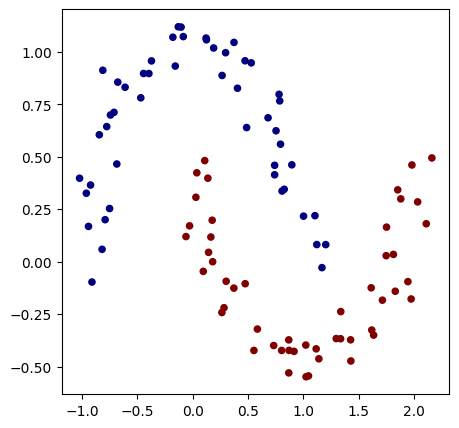

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

- Looks good like a proper non linear dataset

#### Init Model

In [9]:
# 2 layer neural network with 16 nodes in each layer, and one final output node
model = MLP(2, [16, 16, 1])

In [10]:
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


### Loss Function

In [11]:
def loss(batch_size = None):

    #Configuring the Dataloader
    #We can use this as a full batch
    #Or do mini-batches of size 32 to run SGD(Stochastic Gradient Descent)
    if batch_size is None:
        Xb,yb = X,y
    else:
        #To allow for implementation of SGD(Stochastic Gradient Descent) by doing random permutation
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    #Model can't understand float values, so converting everything into a Value Class Object
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    #Forward Pass
    scores = list(map(model, inputs))

    #Using the SVM(Support Vector Machine) "max-margin" loss -> just another kind of loss fxn
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    #L2 Regularization
    #Since large weights cause overfitting, we try to add some weight decay to prevent that
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    #To get the model's accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [12]:
total_loss, acc = loss()
print(total_loss, acc)

Value(data = 1.0114118497514804) 0.5


### Training the Neural Net
- Forward Pass
- Backward Pass
- Gradient Descent, in this case SGD
- Print step, accuracy and loss

In [13]:
#Training/Improving the Neural Net
for k in range(100): #100 Epochs
    
    # forward pass
    total_loss, acc = loss()
    
    # backward pass
    model.zero_grad() #Common Mistake : Forget to reset gradient
    total_loss.backward()
    
    # update weights using gradient descent(sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.0114118497514804, accuracy 50.0%
step 1 loss 0.9823849818691586, accuracy 51.0%
step 2 loss 0.7622455379227289, accuracy 64.0%
step 3 loss 0.5436557194933499, accuracy 73.0%
step 4 loss 0.42766357561004553, accuracy 80.0%
step 5 loss 0.33643628378239915, accuracy 85.0%
step 6 loss 0.2883450680827763, accuracy 88.0%
step 7 loss 0.2628125167311734, accuracy 88.0%
step 8 loss 0.2638981481600432, accuracy 90.0%
step 9 loss 0.3861972988656259, accuracy 83.0%
step 10 loss 0.2829463077269074, accuracy 88.0%
step 11 loss 0.2459367893371052, accuracy 90.0%
step 12 loss 0.21419997890559556, accuracy 91.0%
step 13 loss 0.19975025249473977, accuracy 92.0%
step 14 loss 0.1927149751572854, accuracy 92.0%
step 15 loss 0.18635265816749896, accuracy 92.0%
step 16 loss 0.17964779104413653, accuracy 92.0%
step 17 loss 0.17255128525335092, accuracy 92.0%
step 18 loss 0.16528253904152687, accuracy 93.0%
step 19 loss 0.15968076333201406, accuracy 94.0%
step 20 loss 0.16754365768745993, accurac

### We have gotten 100% accuracy
- Now we need to visualize how the neural net has separated the points

### Visualize Output

(-1.548639298268643, 1.951360701731357)

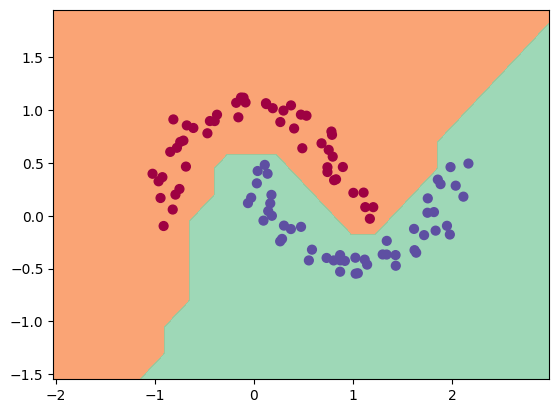

In [17]:
#Setting up the resolution -> Smooth Boundary
h = 0.25

#Find the Boundaries and pad them, creating the outline of the graph
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

#Creating the actual graph
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#Flatten grid into dataset
#We have to give neural net the points not the grid
Xmesh = np.c_[xx.ravel(), yy.ravel()]

#Making it micrograd compatible
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

#Classification of points
scores = list(map(model, inputs))

#Convert Scores to Binary Classes
# > 0 is 1 , and <0 is -1
Z = np.array([s.data > 0 for s in scores])

#Convert entire thing back to grid
Z = Z.reshape(xx.shape)

#Colouring regions based on binary class
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

#Plot the real data points from the make_moon dataset
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

#Clean display
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())